In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
from random import randint
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

## 1. Image Preparation for Convolutional Neural Network with TensorFlow's Keras API

The images included in the data/skin-cancer directory are a random subset of microscopic images of Benign & Malignant Skin Cancer cells from ISIC Data-Base: https://www.isic-archive.com/#!/topWithHeader/onlyHeaderTop/gallery

In [2]:
# Organize data into train directories
os.chdir('C:\\Users\\רועי\\data\\skin-cancer\\benign_set')
if os.path.isdir('C:\\Users\\רועי\\data\\skin-cancer\\train\\benign') is False:
    os.makedirs('C:\\Users\רועי\\data\\skin-cancer\\train\\benign')
    
    for i in random.sample(glob.glob('*'), 500):
        shutil.move(i, 'C:\\Users\\רועי\\data\\skin-cancer\\train\\benign')  
os.chdir('../../')

In [3]:
# Organize data into train directories
os.chdir('C:\\Users\\רועי\\data\\skin-cancer\\malignant_set')
if os.path.isdir('C:\\Users\\רועי\\data\\skin-cancer\\train\\malignant') is False:
    os.makedirs('C:\\Users\רועי\\data\\skin-cancer\\train\\malignant')
    
    for i in random.sample(glob.glob('*'), 500):
        shutil.move(i, 'C:\\Users\\רועי\\data\\skin-cancer\\train\\malignant')  
os.chdir('../../')

In [4]:
# Organize data into valid directories
os.chdir('C:\\Users\\רועי\\data\\skin-cancer\\benign_set')
if os.path.isdir('C:\\Users\\רועי\\data\\skin-cancer\\valid\\benign') is False:
    os.makedirs('C:\\Users\רועי\\data\\skin-cancer\\valid\\benign')
    
    for i in random.sample(glob.glob('*'), 100):
        shutil.move(i, 'C:\\Users\\רועי\\data\\skin-cancer\\valid\\benign')  
os.chdir('../../')

In [5]:
# Organize data into valid directories
os.chdir('C:\\Users\\רועי\\data\\skin-cancer\\malignant_set')
if os.path.isdir('C:\\Users\\רועי\\data\\skin-cancer\\valid\\malignant') is False:
    os.makedirs('C:\\Users\רועי\\data\\skin-cancer\\valid\\malignant')
    
    for i in random.sample(glob.glob('*'), 100):
        shutil.move(i, 'C:\\Users\\רועי\\data\\skin-cancer\\valid\\malignant')  
os.chdir('../../')

In [6]:
train_path = 'C:\\Users\\רועי\\\data\\skin-cancer\\train'
valid_path = 'C:\\Users\\רועי\\\data\\skin-cancer\\valid'

In [7]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), classes=['benign','malignant'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224), classes=['benign','malignant'], batch_size=10)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [8]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert train_batches.num_classes == valid_batches.num_classes == 2

In [9]:
# plot images in the form of a 1 by 10 grid and resize img to 20x20
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

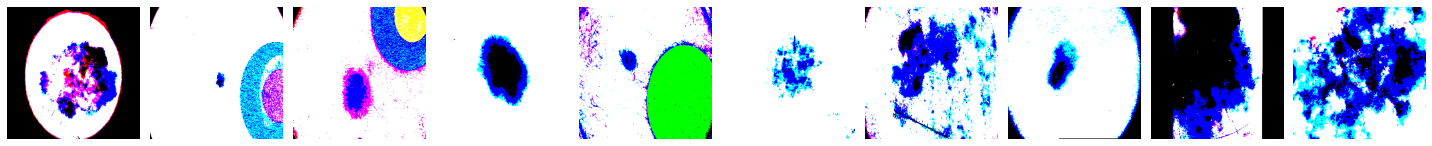

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [10]:
train_imgs, train_labels = next(train_batches)
plotImages(train_imgs)
print(train_labels)

## 2. Create a Convolutional Neural Network with TensorFlow's Keras API

In [11]:
pysical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(pysical_devices))

Num GPUs Available:  0


In [12]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

## 3. Train a Convolutional Neural Network with TensorFlow's Keras API

In [15]:
X_train = train_batches
y_train = train_batches.classes

In [16]:
model.fit(x=X_train, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
100/100 - 579s - loss: 13.1146 - acc: 0.6710 - val_loss: 2.3796 - val_acc: 0.8000
Epoch 2/10
100/100 - 498s - loss: 2.3837 - acc: 0.8200 - val_loss: 1.5819 - val_acc: 0.8050
Epoch 3/10
100/100 - 505s - loss: 1.1106 - acc: 0.8580 - val_loss: 1.9547 - val_acc: 0.7700
Epoch 4/10
100/100 - 488s - loss: 1.4272 - acc: 0.8570 - val_loss: 1.4220 - val_acc: 0.8150
Epoch 5/10
100/100 - 495s - loss: 0.2600 - acc: 0.9520 - val_loss: 1.2719 - val_acc: 0.8250
Epoch 6/10
100/100 - 497s - loss: 0.1111 - acc: 0.9640 - val_loss: 1.1389 - val_acc: 0.8550
Epoch 7/10
100/100 - 490s - loss: 0.0317 - acc: 0.9870 - val_loss: 1.0048 - val_acc: 0.8550
Epoch 8/10
100/100 - 618s - loss: 0.0117 - acc: 0.9960 - val_loss: 0.9839 - val_acc: 0.8300
Epoch 9/10
100/100 - 605s - loss: 0.0053 - acc: 0.9990 - val_loss: 1.0217 - val_acc: 0.8300
Epoch 10/10
100/100 - 273s - loss: 0.0015 - acc: 1.0000 - val_loss: 1.0338 - val_acc: 0.8400


## 4. Build a Test Set with TensorFlow's Keras API

In [17]:
# Organize data into test directories
os.chdir('C:\\Users\רועי\\data\\skin-cancer\\benign_set')
if os.path.isdir('C:\\Users\\רועי\\data\\skin-cancer\\test\\benign') is False:
    os.makedirs('C:\\Users\רועי\\data\\skin-cancer\\test\\benign')
    
    for i in random.sample(glob.glob('*'), 50):
        shutil.move(i, 'C:\\Users\\רועי\\data\\skin-cancer\\test\\benign')  
os.chdir('../../')

In [18]:
# Organize data into test directories
os.chdir('C:\\Users\רועי\\data\\skin-cancer\\malignant_set')
if os.path.isdir('C:\\Users\\רועי\\data\\skin-cancer\\test\\malignant') is False:
    os.makedirs('C:\\Users\רועי\\data\\skin-cancer\\test\\malignant')
    
    for i in random.sample(glob.glob('*'), 50):
        shutil.move(i, 'C:\\Users\\רועי\\data\\skin-cancer\\test\\malignant')  
os.chdir('../../')

In [19]:
test_path  = 'C:\\Users\\רועי\\\data\\skin-cancer\\test'

In [20]:
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224),   classes=['benign','malignant'], batch_size=10, shuffle=False)

Found 100 images belonging to 2 classes.


In [21]:
assert test_batches.n == 100
assert test_batches.num_classes == 2

## 5. Neural Network Predictions with TensorFlow's Keras API

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

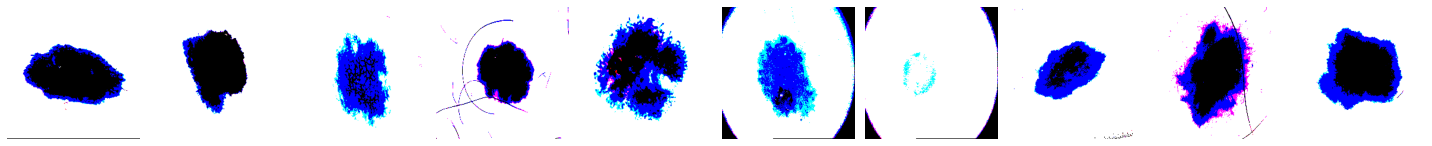

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [22]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [23]:
X_test = test_batches
y_test = test_batches.classes

In [24]:
predictions = model.predict(x=X_test, verbose=0)

In [25]:
for i in predictions:
    print(i)

[0.9802997 0.0197003]
[1.9541885e-08 1.0000000e+00]
[9.994773e-01 5.227418e-04]
[0.00325469 0.99674535]
[0.9803562  0.01964379]
[1.000000e+00 8.721857e-12]
[9.9999475e-01 5.2028295e-06]
[0.99301404 0.00698605]
[0.66946095 0.3305391 ]
[9.9999416e-01 5.8842506e-06]
[0.03981518 0.9601849 ]
[9.999914e-01 8.576671e-06]
[0.99464583 0.00535418]
[0.9292744  0.07072559]
[1.0000000e+00 2.8359781e-19]
[1.0000000e+00 1.7173389e-10]
[1.000000e+00 9.781411e-14]
[1.0000000e+00 1.9528143e-11]
[1.000000e+00 7.286939e-12]
[9.9978834e-01 2.1172139e-04]
[1.0000000e+00 2.0280114e-27]
[9.950802e-04 9.990049e-01]
[1. 0.]
[1.000000e+00 2.120807e-15]
[1. 0.]
[1. 0.]
[1.0000000e+00 5.3565987e-08]
[0.00403944 0.99596053]
[1.0000000e+00 6.4680587e-20]
[1. 0.]
[1.000000e+00 9.792155e-12]
[1.0000000e+00 2.0098035e-21]
[1.0000000e+00 2.2461985e-21]
[1.0000000e+00 4.5110513e-16]
[1. 0.]
[1.0000000e+00 2.2244064e-11]
[1.0000000e+00 5.6124617e-14]
[1.000000e+00 2.473145e-08]
[1.0000000e+00 1.8341895e-13]
[1.0000000e+00

In [26]:
rounded_predictions = np.argmax(np.round(predictions), axis=-1)  

In [27]:
for i in rounded_predictions:
    print(i)

0
1
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
1
1
1
1
1
1
1
0
1
1
1
1
1
0
1
1
0
1
1
1
1
1
1
1
1
1
1
1
0
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


## 6. Create a Confusion Matrix for Neural Network Predictions

In [28]:
y_pred=rounded_predictions

In [29]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[43  7]
 [ 6 44]]


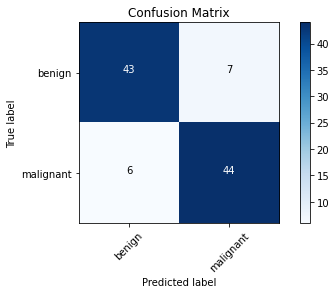

In [31]:
cm_plot_labels = ['benign','malignant']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [32]:
print("\033[1m The result is telling us that we have: ",(cm[0,0]+cm[1,1]),"correct predictions.")
print("\033[1m The result is telling us that we have: ",(cm[0,1]+cm[1,0]),"incorrect predictions.")
print("\033[1m We have a total predictions of: ",(cm.sum()))

 The result is telling us that we have:  87 correct predictions.
 The result is telling us that we have:  13 incorrect predictions.
 We have a total predictions of:  100


## 7. Create a Classification Report for Neural Network Predictions

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87        50
           1       0.86      0.88      0.87        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



In [34]:
#calculate Accuracy, how often is the classifier correct?
print("Accuracy of the Convolutional Neural Network model:", "{:.2%}".format(metrics.accuracy_score(y_test, y_pred)))
print("\nWell, you got a classification rate of", "{:.2%}".format(metrics.accuracy_score(y_test, y_pred)))

Accuracy of the Convolutional Neural Network model: 87.00%

Well, you got a classification rate of 87.00%


In [35]:
#calculate Precision
print("Precision of the Convolutional Neural Network model:", "{:.2%}".format(metrics.precision_score(y_test, y_pred)))
print("\nPrecision: Precision is about being precise, i.e., how precise our model is. In other words, we can say, when a model makes a prediction, how often it is correct. In our prediction case, when our Convolutional Neural Network model predicted an image is of a malignant skin cancer cell, that image is actually of a malignant skin cancer cell", "{:.2%}".format(metrics.precision_score(y_test, y_pred)) ,"of the time.")

Precision of the Convolutional Neural Network model: 86.27%

Precision: Precision is about being precise, i.e., how precise our model is. In other words, we can say, when a model makes a prediction, how often it is correct. In our prediction case, when our Convolutional Neural Network model predicted an image is of a malignant skin cancer cell, that image is actually of a malignant skin cancer cell 86.27% of the time.


In [36]:
#calculate Recall
print("Recall of the Convolutional Neural Network model:", "{:.2%}".format(metrics.recall_score(y_test, y_pred)))
print("\nRecall: If there is an image of a malignant skin cancer cell present in the test set, our Convolutional Neural Network model can identify it", "{:.2%}".format(metrics.recall_score(y_test, y_pred)) ,"of the time.")

Recall of the Convolutional Neural Network model: 88.00%

Recall: If there is an image of a malignant skin cancer cell present in the test set, our Convolutional Neural Network model can identify it 88.00% of the time.


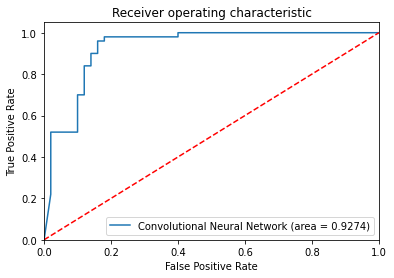

In [37]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
cnn_roc_auc = roc_auc_score(y_test, model.predict(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Convolutional Neural Network (area = %0.4f)' % cnn_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('CNN_ROC')
plt.show()

## 8. Deployment of the Convolutional Neural Network

Found 1 images belonging to 2 classes.


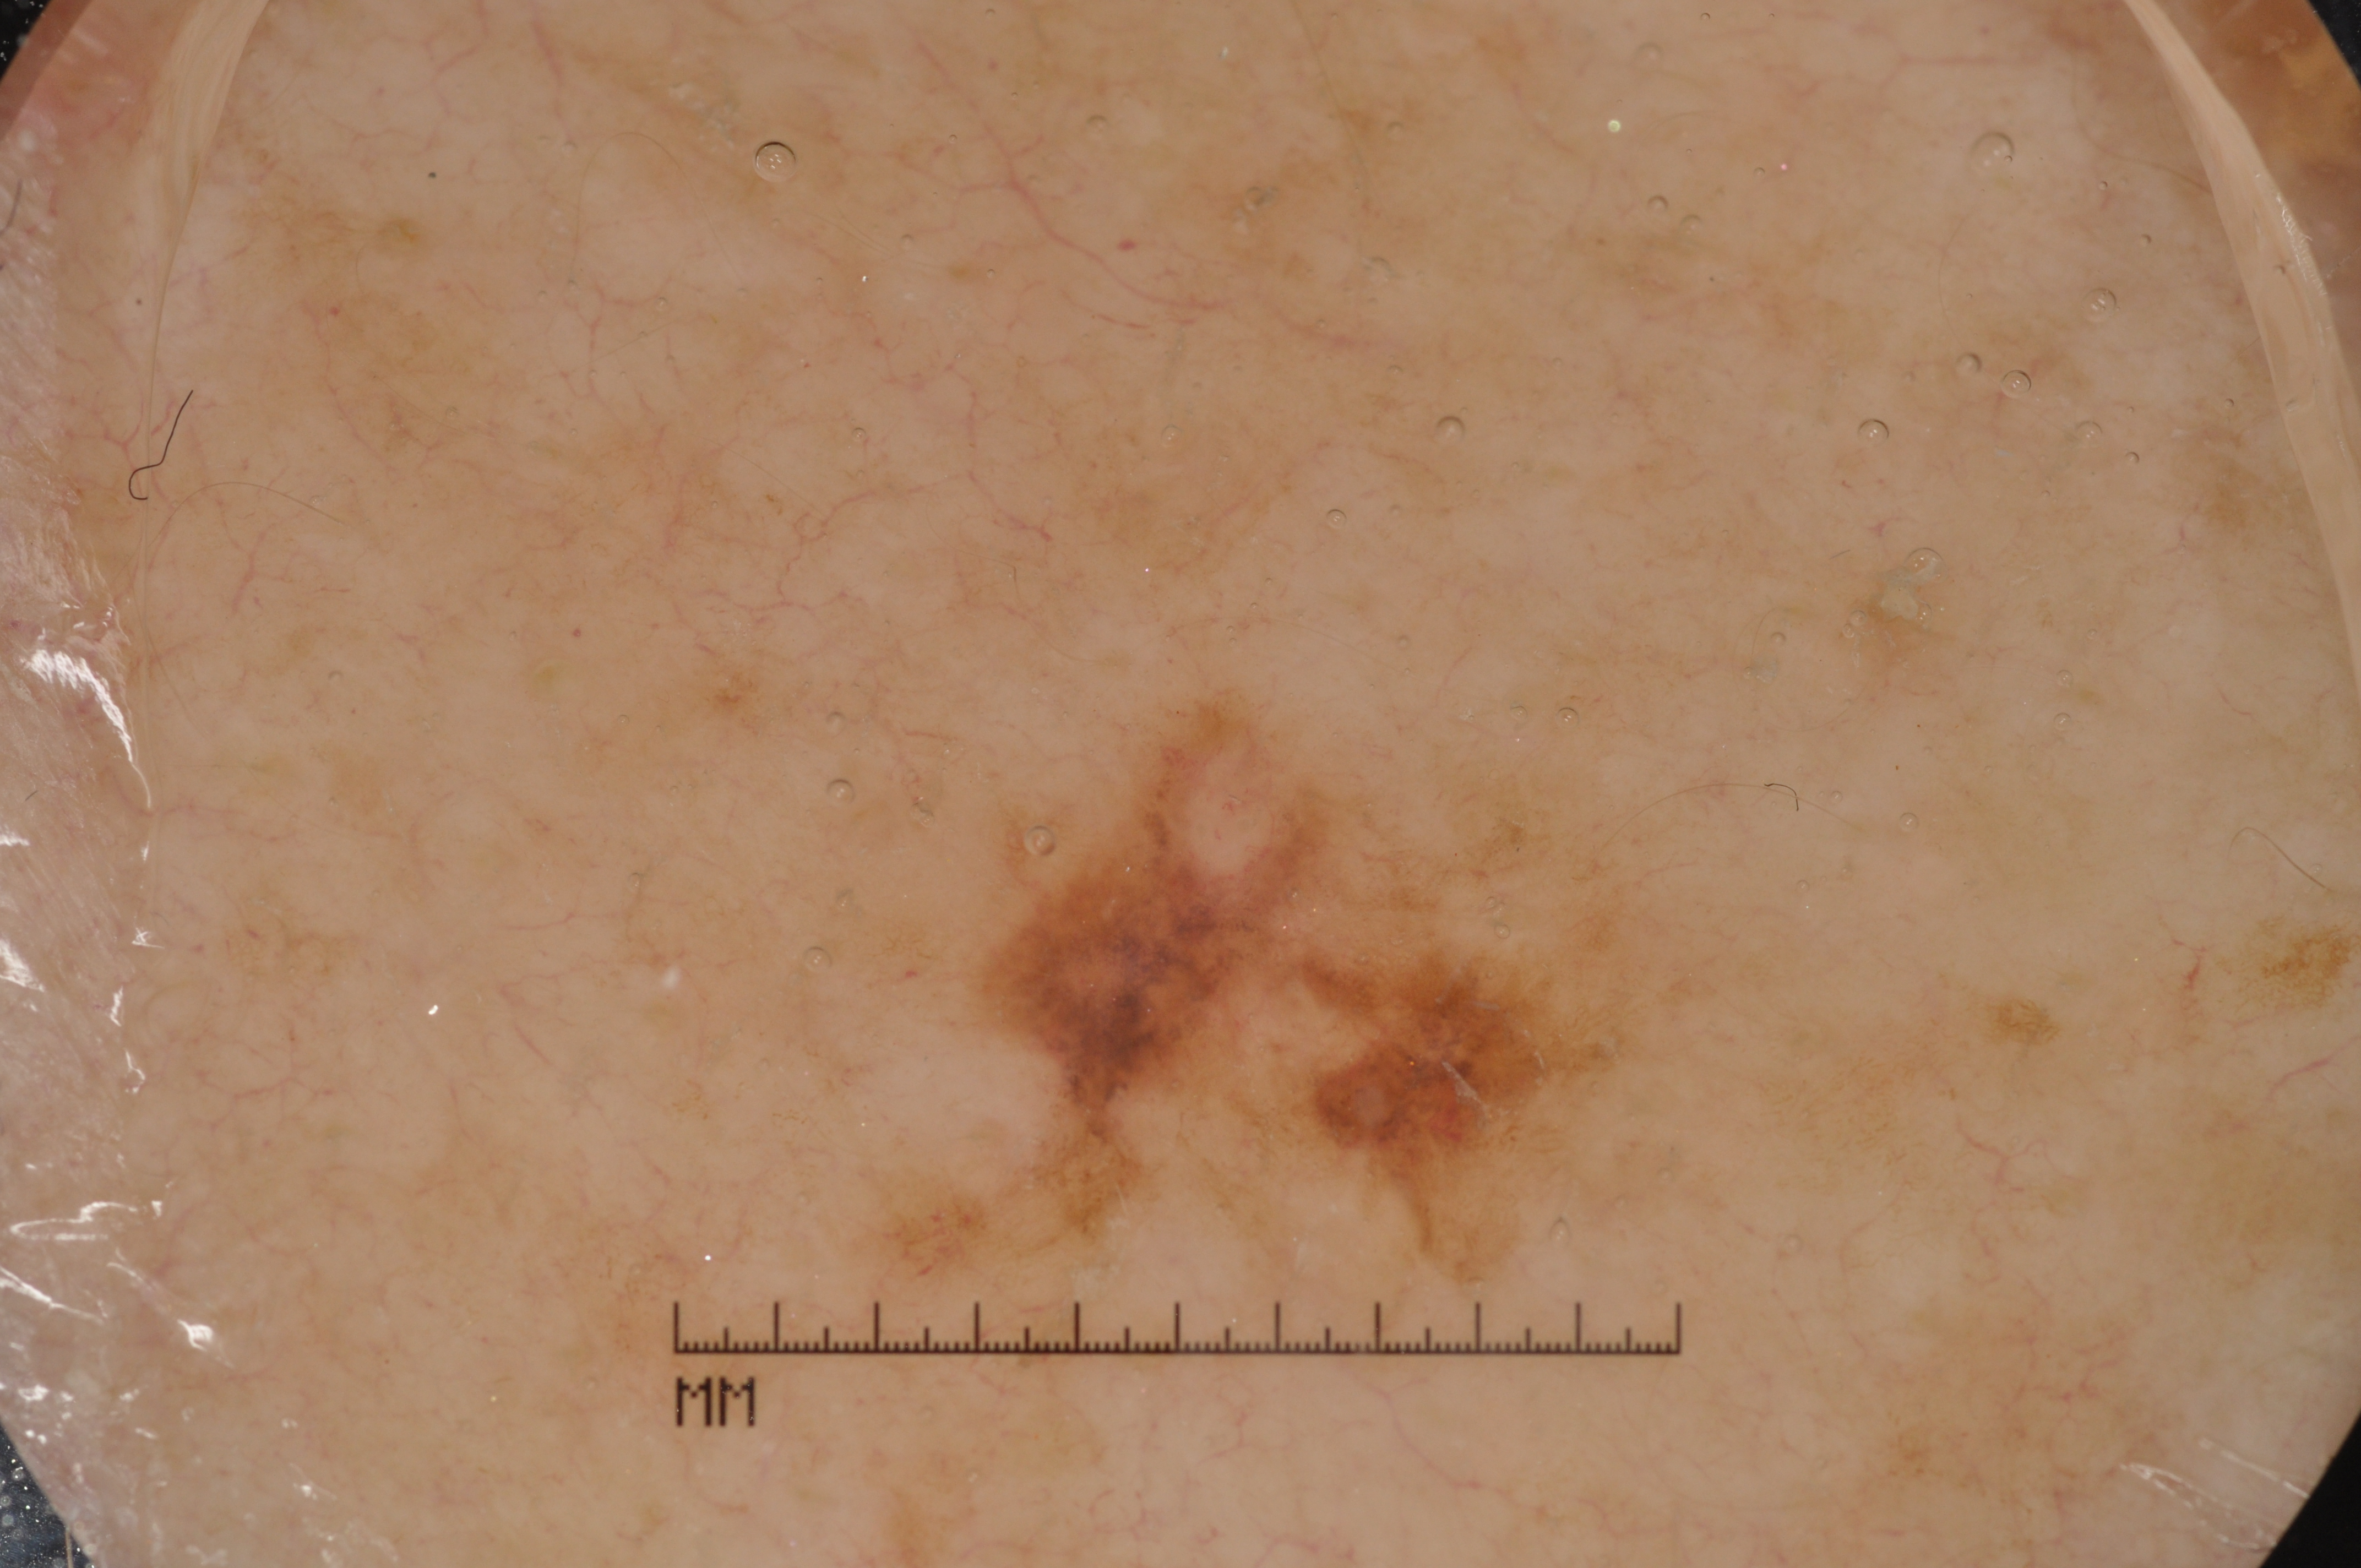

In [38]:
randy = randint(0,1)
if randy == 0:
    os.chdir('C:\\Users\\רועי\\data\\skin-cancer\\benign_set')
    if os.path.isdir('C:\\Users\\רועי\\data\\skin-cancer\\pred\\benign') is False:
        os.makedirs('C:\\Users\רועי\\data\\skin-cancer\\pred\\benign')
        for i in random.sample(glob.glob('*'), 1):
            shutil.move(i, 'C:\\Users\\רועי\\data\\skin-cancer\\pred\\benign')  
    os.chdir('../../')
else:
    os.chdir('C:\\Users\\רועי\\data\\skin-cancer\\malignant_set')
    if os.path.isdir('C:\\Users\\רועי\\data\\skin-cancer\\pred\\malignant') is False:
        os.makedirs('C:\\Users\רועי\\data\\skin-cancer\\pred\\malignant')
        for i in random.sample(glob.glob('*'), 1):
            shutil.move(i, 'C:\\Users\\רועי\\data\\skin-cancer\\pred\\malignant')  
    os.chdir('../../')

pred_path = 'C:\\Users\רועי\\data\\skin-cancer\\pred'

if randy == 0:
    pred_pic1 = 'C:\\Users\רועי\\data\\skin-cancer\\pred\\benign' 
else:
    pred_pic1 = 'C:\\Users\רועי\\data\\skin-cancer\\pred\\malignant'
    
pred_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=pred_path, target_size=(224,224),   classes=['benign','malignant'], batch_size=10, shuffle=False)

assert pred_batches.n == 1
assert pred_batches.num_classes == 2

from IPython.display import Image
if randy == 0:
    os.chdir('C:\\Users\רועי\\data\\skin-cancer\\pred\\benign')
    for i in random.sample(glob.glob('*'), 1):
        Image(filename=i)

else:
    os.chdir('C:\\Users\רועי\\data\\skin-cancer\\pred\\malignant')
    for i in random.sample(glob.glob('*'), 1):
        Image(filename=i)
    
Image(filename=i)

In [39]:
if randy == 0:
    print("\033[1m This is an image of a benign skin cancer cell")
else:
    print("\033[1m This is an image of a malignant skin cancer cell")

 This is an image of a malignant skin cancer cell


In [40]:
accuracy = "{:.2%}".format(metrics.accuracy_score(y_test, y_pred))
pred_imgs, pred_labels = next(pred_batches)
X_pred = pred_batches
y_pred = pred_batches.classes
pred = model.predict(x=X_pred, verbose=0)
rounded_pred = np.argmax(np.round(pred), axis=-1) 
if rounded_pred[0] == 0:
    print("\033[1m The algorithm predict, with accuracy (i.e., confidence level) of", accuracy, "that this is an image of a benign skin cancer cell")
else:
    print("\033[1m The algorithm predict, with accuracy (i.e., confidence level) of", accuracy, "that this is an image of a malignant skin cancer cell")

 The algorithm predict, with accuracy (i.e., confidence level) of 87.00% that this is an image of a malignant skin cancer cell


## 9. Save and Load a Model with TensorFlow's Keras API

### 1. model.save()

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In [42]:
# Checks first to see if file exists already
# If not, the model is saved to disk.
import os.path
if os.path.isfile('C:\\Users\\רועי\\models\\skincancer_model.h7') is False:
    model.save('C:\\Users\\רועי\\models\skincancer_model.h7')

This save functions saves:
1. The architecture of the model allowing to re-create the moddel.
2. The weights of the model.
3. The training configuration (loss, optimizer).
4. The state of the optimizer, allowing to resume training exactly where you left off.

In [43]:
from tensorflow.keras.models import load_model
new_model = load_model('C:\\Users\\רועי\\models\\skincancer_model.h7')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [44]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In [45]:
new_model.get_weights()

[array([[[[ 1.38012096e-01, -8.84406865e-02,  1.20834507e-01,
            1.20329633e-01, -1.16766378e-01,  7.45493323e-02,
           -1.34152964e-01, -1.15893736e-01, -8.40075389e-02,
           -7.46510699e-02,  1.33424535e-01, -7.51701277e-03,
           -3.67834829e-02,  8.52866620e-02, -1.00812070e-01,
           -1.64543353e-02, -9.01955739e-03,  1.06778115e-01,
           -7.34757707e-02,  7.54573047e-02, -5.29317670e-02,
            9.08764452e-02, -1.27979338e-01, -3.71927186e-03,
           -2.38801409e-02, -1.02364317e-01, -1.08862691e-01,
            1.25361934e-01, -8.83691981e-02,  3.83781604e-02,
            7.98096731e-02, -1.16856664e-01],
          [ 6.22796603e-02, -7.23754466e-02, -9.91126373e-02,
            8.96538347e-02,  2.31015757e-02, -7.83761218e-02,
            2.62644459e-02,  1.14494003e-01,  9.14754421e-02,
            1.14326626e-02, -7.66148865e-02, -7.30372369e-02,
           -2.92360950e-02, -1.10828280e-01,  1.34554029e-01,
            4.18831706e-

In [46]:
new_model.optimizer

### 2. model.to_json()

if you only need to save architecture of a model, and not its weights or its training configuration, you can see the following function to save the architecture only.

In [47]:
# save as YAML
yaml_string = model.to_yaml()

# save as JSON
# json_string = model.to_json()

In [48]:
yaml_string

'backend: tensorflow\nclass_name: Sequential\nconfig:\n  layers:\n  - class_name: Conv2D\n    config:\n      activation: relu\n      activity_regularizer: null\n      batch_input_shape: !!python/tuple\n      - null\n      - 224\n      - 224\n      - 3\n      bias_constraint: null\n      bias_initializer:\n        class_name: Zeros\n        config:\n          dtype: float32\n      bias_regularizer: null\n      data_format: channels_last\n      dilation_rate: &id001 !!python/tuple\n      - 1\n      - 1\n      dtype: float32\n      filters: 32\n      kernel_constraint: null\n      kernel_initializer:\n        class_name: GlorotUniform\n        config:\n          dtype: float32\n          seed: null\n      kernel_regularizer: null\n      kernel_size: &id002 !!python/tuple\n      - 3\n      - 3\n      name: conv2d\n      padding: same\n      strides: *id001\n      trainable: true\n      use_bias: true\n  - class_name: MaxPooling2D\n    config:\n      data_format: channels_last\n      dtype:

In [49]:
# model reconstruction from YAML
from tensorflow.keras.models import model_from_yaml
model_architecture = model_from_yaml(yaml_string)

# model reconstruction from JSON:
# from tensorflow.keras.models import model_from_json
# model_architecture = model_from_json(json_string)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\saving\model_config.py:76: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(yaml_string)


In [50]:
model_architecture.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

### 3. model.save_weights()

If you only need to save the weights of the model, you cab use the following function save the weights only.

In [51]:
# Checks first to see if file exists already
# If not, the model is saved to disk.
import os.path
if os.path.isfile('C:\\Users\\רועי\\models\skincancer_model.h7') is False:
    model.save_weights('C:\\Users\\רועי\\models\skincancer_model.h7')

In [52]:
model2 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [53]:
model2.load_weights('C:\\Users\\רועי\\models\skincancer_model.h7')

In [54]:
model2.get_weights()

[array([[[[ 1.38012096e-01, -8.84406865e-02,  1.20834507e-01,
            1.20329633e-01, -1.16766378e-01,  7.45493323e-02,
           -1.34152964e-01, -1.15893736e-01, -8.40075389e-02,
           -7.46510699e-02,  1.33424535e-01, -7.51701277e-03,
           -3.67834829e-02,  8.52866620e-02, -1.00812070e-01,
           -1.64543353e-02, -9.01955739e-03,  1.06778115e-01,
           -7.34757707e-02,  7.54573047e-02, -5.29317670e-02,
            9.08764452e-02, -1.27979338e-01, -3.71927186e-03,
           -2.38801409e-02, -1.02364317e-01, -1.08862691e-01,
            1.25361934e-01, -8.83691981e-02,  3.83781604e-02,
            7.98096731e-02, -1.16856664e-01],
          [ 6.22796603e-02, -7.23754466e-02, -9.91126373e-02,
            8.96538347e-02,  2.31015757e-02, -7.83761218e-02,
            2.62644459e-02,  1.14494003e-01,  9.14754421e-02,
            1.14326626e-02, -7.66148865e-02, -7.30372369e-02,
           -2.92360950e-02, -1.10828280e-01,  1.34554029e-01,
            4.18831706e-

# 10. Clean and Delete all the Directories

In [55]:
# Delete data from train directories
os.chdir('C:\\Users\\רועי\\data\\skin-cancer\\train\\benign')
for i in random.sample(glob.glob('*'), 500):
    shutil.move(i, 'C:\\Users\\רועי\\data\\skin-cancer\\benign_set')  
os.chdir('../../')
os.removedirs('C:\\Users\רועי\\data\\skin-cancer\\train\\benign')
os.chdir('../../')

# Delete data from train directories
os.chdir('C:\\Users\\רועי\\data\\skin-cancer\\train\\malignant')
if os.path.isdir('C:\\Users\\רועי\\data\\skin-cancer\\malignant_set') is False:
    os.makedirs('C:\\Users\רועי\\data\\skin-cancer\\malignant_set')
for i in random.sample(glob.glob('*'), 500):
    shutil.move(i, 'C:\\Users\\רועי\\data\\skin-cancer\\malignant_set')  
os.chdir('../../')
os.removedirs('C:\\Users\רועי\\data\\skin-cancer\\train\\malignant')
os.chdir('../../')

In [56]:
# Delete data from train directories
os.chdir('C:\\Users\\רועי\\data\\skin-cancer\\valid\\benign')
for i in random.sample(glob.glob('*'), 100):
    shutil.move(i, 'C:\\Users\\רועי\\data\\skin-cancer\\benign_set')  
os.chdir('../../')
os.removedirs('C:\\Users\רועי\\data\\skin-cancer\\valid\\benign')
os.chdir('../../')

# Delete data from valid directories
os.chdir('C:\\Users\\רועי\\data\\skin-cancer\\valid\\malignant')
if os.path.isdir('C:\\Users\\רועי\\data\\skin-cancer\\malignant_set') is False:
    os.makedirs('C:\\Users\רועי\\data\\skin-cancer\\malignant_set')
for i in random.sample(glob.glob('*'), 100):
    shutil.move(i, 'C:\\Users\\רועי\\data\\skin-cancer\\malignant_set')  
os.chdir('../../')
os.removedirs('C:\\Users\רועי\\data\\skin-cancer\\valid\\malignant')
os.chdir('../../')

In [57]:
# Delete data from test directories
os.chdir('C:\\Users\\רועי\\data\\skin-cancer\\test\\benign')
for i in random.sample(glob.glob('*'), 50):
    shutil.move(i, 'C:\\Users\\רועי\\data\\skin-cancer\\benign_set')  
os.chdir('../../')
os.removedirs('C:\\Users\רועי\\data\\skin-cancer\\test\\benign')
os.chdir('../../')

# Delete data from test directories
os.chdir('C:\\Users\\רועי\\data\\skin-cancer\\test\\malignant')
if os.path.isdir('C:\\Users\\רועי\\data\\skin-cancer\\malignant_set') is False:
    os.makedirs('C:\\Users\רועי\\data\\skin-cancer\\malignant_set')
for i in random.sample(glob.glob('*'), 50):
    shutil.move(i, 'C:\\Users\\רועי\\data\\skin-cancer\\malignant_set')  
os.chdir('../../')
os.removedirs('C:\\Users\רועי\\data\\skin-cancer\\test\\malignant')
os.chdir('../../')

In [58]:
if randy == 0:
    # Delete data from pred directories
    os.chdir('C:\\Users\\רועי\\data\\skin-cancer\\pred\\benign')
    for i in random.sample(glob.glob('*'), 1):
        shutil.move(i, 'C:\\Users\\רועי\\data\\skin-cancer\\benign_set')  
    os.chdir('../../')
    os.removedirs('C:\\Users\רועי\\data\\skin-cancer\\pred\\benign')
else:
    # Delete data from pred directories
    os.chdir('C:\\Users\\רועי\\data\\skin-cancer\\pred\\malignant')
    for i in random.sample(glob.glob('*'), 1):
        shutil.move(i, 'C:\\Users\\רועי\\data\\skin-cancer\\malignant_set')  
    os.chdir('../../')
    os.removedirs('C:\\Users\רועי\\data\\skin-cancer\\pred\\malignant')